In [ ]:
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials 
  
  
# Authenticate and create the PyDrive client. 
auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

In [ ]:
#This part linkes the dataset in the drive to the google colab file
link =  'https://drive.google.com/file/d/1GTpBieM7QsYuUjtwNDCsRhBTA58Q5Xu_/view?usp=sharing' #Moving Average
link2 = 'https://drive.google.com/file/d/13F66zwrZcZjTNnZbjgaHZsp3WPD_85RG/view?usp=sharing' #Actual Prices
link3 = 'https://drive.google.com/file/d/1VEF6Ld9Wv3MLcLRngl4PoiFFDPPrdn4V/view?usp=sharing' #PCA Predicted
link4 = 'https://drive.google.com/file/d/1--lXVFUvLEFyIw-jCCMxDb_1FXRcrDWP/view?usp=sharing' #LR Predicted
link5 = 'https://drive.google.com/file/d/1--TuLrE_BmRqOMSMLETiaW4bB3qmioJZ/view?usp=sharing' #PCA Actuals
link6 = 'https://drive.google.com/file/d/1-26dFRXBRlVJPuUGD1Rn6VO0j6Hc65yC/view?usp=sharing' #LR Actuals

id = link.split('/')[-2]
id2 = link2.split('/')[-2]
id3 = link3.split('/')[-2]
id4 = link4.split('/')[-2]
id5 = link5.split('/')[-2]
id6 = link6.split('/')[-2]
# id7 = link7.split('/')[-2]

downloaded = drive.CreateFile({'id' : id})
downloaded2 = drive.CreateFile({'id' : id2})
downloaded3 = drive.CreateFile({'id' : id3})
downloaded4 = drive.CreateFile({'id' : id4})
downloaded5 = drive.CreateFile({'id' : id5})
downloaded6 = drive.CreateFile({'id' : id6})



downloaded.GetContentFile('MovingAverage.csv')
downloaded.GetContentFile('y_dataset.csv')
downloaded3.GetContentFile('PCA_Predicted_Prices1.csv')
downloaded4.GetContentFile('LR_Predicted_Prices.csv')
downloaded5.GetContentFile('PCA_Actual_Prices1.csv')
downloaded6.GetContentFile('LR_Actual_prices.csv')

In [ ]:
#S&P 500 Data
"""
link = ''
id7 = link.split('/')[-2]
downloaded7 = drive.CreateFile({'id' : id7})
downloaded7.GetContentFile('SP500.csv')
SP500 = pd.read_csv("SP500.csv")
"""

'\nlink = \'\'\nid7 = link.split(\'/\')[-2]\ndownloaded7 = drive.CreateFile({\'id\' : id7})\ndownloaded7.GetContentFile(\'SP500.csv\')\nSP500 = pd.read_csv("SP500.csv")\n'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Model 1: Moving Average
Moving_Average = pd.read_csv('MovingAverage.csv')
Moving_Average['Date'] =  pd.to_datetime(Moving_Average['Date'])
Moving_Average=Moving_Average.set_index('Date')

Closing_Prices = pd.read_csv('y_dataset.csv')
Closing_Prices['Date'] =  pd.to_datetime(Closing_Prices['Date'])
Closing_Prices=Closing_Prices.set_index('Date')


#Model 2: Linear Regression
LR_Predicted_Prices = pd.read_csv('LR_Predicted_Prices.csv')
LR_Predicted_Prices['Date'] =  pd.to_datetime(LR_Predicted_Prices['Date'])
LR_Predicted_Prices=LR_Predicted_Prices.set_index('Date')

LR_Actual_Prices = pd.read_csv('LR_Actual_prices.csv')
LR_Actual_Prices['Date'] =  pd.to_datetime(LR_Actual_Prices['Date'])
LR_Actual_Prices=LR_Actual_Prices.set_index('Date')


#Model 3: LSTM
PCA_Predicted_Prices = pd.read_csv('PCA_Predicted_Prices1.csv')
PCA_Predicted_Prices['Date'] =  pd.to_datetime(PCA_Predicted_Prices['Date'])
PCA_Predicted_Prices=PCA_Predicted_Prices.set_index('Date')

PCA_Actual_Prices = pd.read_csv('PCA_Actual_Prices1.csv')
PCA_Actual_Prices['Date'] =  pd.to_datetime(PCA_Actual_Prices['Date'])
PCA_Actual_Prices=PCA_Actual_Prices.set_index('Date')

In [ ]:
#Computing Log Returns
PCA_Predicted_Returns = PCA_Predicted_Prices.apply(lambda x: np.log(x) - np.log(x.shift(1))).iloc[1:] 
PCA_Actual_Returns = PCA_Actual_Prices.apply(lambda x: np.log(x) - np.log(x.shift(1))).iloc[1:] 

LR_Predicted_Returns = LR_Predicted_Prices.apply(lambda x: np.log(x) - np.log(x.shift(1))).iloc[1:] 
LR_Actual_Returns = LR_Actual_Prices.apply(lambda x: np.log(x) - np.log(x.shift(1))).iloc[1:] 

Closing_Prices_Returns = Closing_Prices.apply(lambda x: np.log(x) - np.log(x.shift(1))).iloc[1:] 

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(PCA_Actual_Prices, PCA_Predicted_Prices)

1822284.255508551

**Creation of Different Lookback and Forward Windows**

In [ ]:
#Mean Returns function
def mean_returns(df, length): 
  mu = df.sum(axis = 0)/length
  return mu

In [ ]:
from datetime import timedelta
from dateutil.parser import parse

def monthdelta(date, delta):
    m, y = (date.month+delta) % 12, date.year + ((date.month)+delta-1) // 12
    if not m: m = 12
    d = min(date.day, [31,
        29 if y%4==0 and not y%400==0 else 28,31,30,31,30,31,31,30,31,30,31][m-1])
    new_date = (date.replace(day=d,month=m, year=y))
    return parse(new_date.strftime('%Y-%m-%d'))


#This part of the code takes in a dataset and splits it into datasets w/ lookback months and forward looking months
def windowGenerator (dataframe, lookback, horizon,
                    step, cummulative = False):

#takes pandas dataframe with DatetimeIndex

    if cummulative:
        c = lookback
        step = horizon
        
    initial = min(dataframe.index)
    windows = []
    horizons = []

    while initial <= monthdelta(max(dataframe.index), -lookback):
        windowStart = initial
        windowEnd = monthdelta(windowStart, lookback)
        if cummulative:
            windowStart = min(dataframe.index)
            windowEnd = monthdelta(windowStart, c) + timedelta(days=1)
            c += horizon
        horizonStart = windowEnd + timedelta(days=1)
        horizonEnd = monthdelta(horizonStart, horizon)

        lookbackWindow = dataframe[windowStart:windowEnd]
        horizonWindow = dataframe[horizonStart:horizonEnd]

        windows.append(lookbackWindow)
        horizons.append(horizonWindow)

        initial = monthdelta(initial, step)

    return windows, horizons

**Optimize Function**

In [ ]:
from scipy.optimize import minimize, Bounds, LinearConstraint
from numpy.linalg import norm

def actual_return(actual_returns, w):
  actual_returns = actual_returns
  mean_return = mean_returns(actual_returns, actual_returns.shape[0])
  actual_covariance = actual_returns.cov()

  portfolio_returns = mean_return.T.dot(w)
  portfolio_variance = w.T.dot(actual_covariance).dot(w)
  return portfolio_returns, portfolio_variance


#Input entire predicted returns df, actual returns df, starting date
def scipy_opt(predicted_returns, actual_returns, lam1, lam2):
  mean_return = mean_returns(predicted_returns, predicted_returns.shape[0])
  predicted_covariance = predicted_returns.cov()
  
  #Cost Function
  def f(w):
    return -(mean_return.T.dot(w) - lam1*(w.T.dot(predicted_covariance).dot(w)) + lam2*norm(w, ord=1))
  #out custom maximises 

  #Bounds of Weights
  opt_bounds = Bounds(0, 1)

  #Equality Constraints
  def h(w):
    return sum(w) - 1

  #Constraints Dictionary
  cons = ({
      'type' : 'eq',
      'fun' : lambda w: h(w)
  })

  #Solver
  sol = minimize(f,
                 x0 = np.ones(mean_return.shape[0]),
                 constraints = cons,
                 bounds = opt_bounds,
                 options = {'disp': False},
                 tol=10e-10)


  #Predicted Results
  w = sol.x
  predicted_portfolio_returns = w.dot(mean_return)
  portfolio_STD = w.T.dot(predicted_covariance).dot(w)
  
  #Actual Results
  portfolio_actual_returns, portfolio_actual_variance = actual_return(actual_returns, w)
  sharpe_ratio = portfolio_actual_returns/np.std(portfolio_actual_variance)

  ret_dict = {'weights' : w,
              'predicted_returns' : predicted_portfolio_returns,
              'predicted_variance' : portfolio_STD,
              'actual_returns' : portfolio_actual_returns,
              'actual_variance' : portfolio_actual_variance,
              'sharpe_ratio': sharpe_ratio}
  
  return ret_dict

**Moving Average **

In [ ]:
#Moving average only needs to look at historical mean returns to make a prediction for the future. It 
#essentially follows the trend of our lookback window
MA_act_windows, MA_act_horizons = windowGenerator(Closing_Prices_Returns, 12, 1, 1)

In [ ]:
MA_scipy_returns= []
MA_scipy_variance = []
MA_scipy_SR = []

# Testing on 5 years of data
for i in range(len(MA_act_horizons)-72,len(MA_act_horizons)-12):
  #Scipy optimize results
  scipy = scipy_opt(MA_act_windows[i], MA_act_horizons[i], .5, 2)
  MA_scipy_returns.append(scipy['actual_returns'])
  MA_scipy_variance.append(scipy['actual_variance'])
  MA_scipy_SR.append(scipy['sharpe_ratio'])
  # print("Month " + str(i) + " complete")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars


In [ ]:
timestamps = []
for i in range(len(MA_act_horizons)-72,len(MA_act_horizons)-12):
  time = MA_act_horizons[i].index[-1]
  timestamps.append(time)

MA_Portfolio_Returns = pd.DataFrame(data = np.array([MA_scipy_returns,MA_scipy_variance,MA_scipy_SR]).T, columns = ['Returns', 'Variance', 'Sharpe Ratio'], index=timestamps)
MA_Portfolio_Returns.index.rename('Date')

MA_Portfolio_Returns.to_csv('MA_Portfolio_Returns.csv')
!cp MA_Portfolio_Returns.csv "drive/My Drive/Machine Learning Project/ML Section Exports"

cp: cannot create regular file 'drive/My Drive/Machine Learning Project/ML Section Exports': No such file or directory


In [ ]:
MA_Portfolio_Returns.head()

,Returns,Variance,Sharpe Ratio
2016-09-29,0.003395,4.657735e-08,inf
2016-10-28,0.003175,2.549033e-08,inf
2016-11-29,0.002021,2.189708e-07,inf
2016-12-29,0.001488,7.121662e-08,inf
2017-01-27,0.001409,3.558048e-08,inf


**Method 2: PCA + Linear Regression**

In [ ]:
LR_pred_windows, LR_pred_horizons = windowGenerator(LR_Predicted_Returns, 12, 1, 1)
LR_act_windows, LR_act_horizons = windowGenerator(LR_Actual_Returns, 12, 1, 1)

In [ ]:
LR_scipy_returns= []
LR_scipy_variance = []
LR_scipy_SR = []

#Testing on 5 years of data
for i in range(len(LR_act_horizons)-72,len(LR_act_horizons)-12):
  #Scipy optimize results
  scipy = scipy_opt(LR_pred_horizons[i], LR_act_horizons[i], .5, 2)
  LR_scipy_returns.append(scipy['actual_returns'])
  LR_scipy_variance.append(scipy['actual_variance'])
  LR_scipy_SR.append(scipy['sharpe_ratio'])
  # print("Month " + str(i) + " complete")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars


In [ ]:
timestamps = []
for i in range(len(LR_act_horizons)-72,len(LR_act_horizons)-12):
  time = LR_act_horizons[i].index[-1]
  timestamps.append(time)

LR_Portfolio_Returns = pd.DataFrame(data = np.array([LR_scipy_returns,LR_scipy_variance,LR_scipy_SR]).T, columns = ['Returns', 'Variance', 'Sharpe Ratio'], index=timestamps)

In [ ]:
# Exporting the Dataset
from google.colab import drive
drive.mount('drive')

LR_Portfolio_Returns.to_csv('LR_Portfolio_Returns.csv')
!cp LR_Portfolio_Returns.csv "drive/My Drive/Machine Learning Project/ML Section Exports"

Mounted at drive


**Method 3: LSTM + PCA**

In [ ]:
LSTM_pred_windows, LSTM_pred_horizons = windowGenerator(PCA_Predicted_Returns,12,1,1)
LSTM_act_windows, LSTM_act_horizons = windowGenerator(PCA_Actual_Returns,12,1,1)

In [ ]:
len(LSTM_pred_horizons)

83

In [ ]:
scipy_returns= []
scipy_variance = []
scipy_SR = []


for i in range(len(LSTM_act_horizons)-60,len(LSTM_act_horizons)):
  #Scipy optimize results
  scipy = scipy_opt(LSTM_pred_horizons[i], LSTM_act_horizons[i], .5, 2)
  scipy_returns.append(scipy['actual_returns'])
  scipy_variance.append(scipy['actual_variance'])
  scipy_SR.append(scipy['sharpe_ratio'])
  print("Month " + str(i) + " complete")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars


Month 23 complete
Month 24 complete
Month 25 complete
Month 26 complete
Month 27 complete
Month 28 complete
Month 29 complete
Month 30 complete
Month 31 complete
Month 32 complete
Month 33 complete
Month 34 complete
Month 35 complete
Month 36 complete
Month 37 complete
Month 38 complete
Month 39 complete
Month 40 complete
Month 41 complete
Month 42 complete
Month 43 complete
Month 44 complete
Month 45 complete
Month 46 complete
Month 47 complete
Month 48 complete
Month 49 complete
Month 50 complete
Month 51 complete
Month 52 complete
Month 53 complete
Month 54 complete
Month 55 complete
Month 56 complete
Month 57 complete
Month 58 complete
Month 59 complete
Month 60 complete
Month 61 complete
Month 62 complete
Month 63 complete
Month 64 complete
Month 65 complete
Month 66 complete
Month 67 complete
Month 68 complete
Month 69 complete
Month 70 complete
Month 71 complete
Month 72 complete
Month 73 complete
Month 74 complete
Month 75 complete
Month 76 complete
Month 77 complete
Month 78 c

In [ ]:
timestamps = []
for i in range(len(LSTM_act_horizons)-60,len(LSTM_act_horizons)):
  time = LSTM_act_horizons[i].index[0]
  timestamps.append(time)
  

LSTM_Portfolio_Returns = pd.DataFrame(data = np.array([scipy_returns,scipy_variance,scipy_SR]).T, columns = ['Returns', 'Variance', 'Sharpe Ratio'], index=timestamps)

LSTM_Portfolio_Returns.to_csv('LSTM_Portfolio_Returns.csv')
!cp LSTM_Portfolio_Returns.csv "drive/My Drive/Machine Learning Project/ML Section Exports"

In [ ]:
timestamps

[Timestamp('2016-07-29 00:00:00'),
 Timestamp('2016-08-29 00:00:00'),
 Timestamp('2016-09-29 00:00:00'),
 Timestamp('2016-11-01 00:00:00'),
 Timestamp('2016-11-29 00:00:00'),
 Timestamp('2016-12-29 00:00:00'),
 Timestamp('2017-01-30 00:00:00'),
 Timestamp('2017-03-01 00:00:00'),
 Timestamp('2017-03-29 00:00:00'),
 Timestamp('2017-05-02 00:00:00'),
 Timestamp('2017-05-29 00:00:00'),
 Timestamp('2017-06-29 00:00:00'),
 Timestamp('2017-07-31 00:00:00'),
 Timestamp('2017-08-29 00:00:00'),
 Timestamp('2017-09-29 00:00:00'),
 Timestamp('2017-10-30 00:00:00'),
 Timestamp('2017-11-29 00:00:00'),
 Timestamp('2017-12-29 00:00:00'),
 Timestamp('2018-01-29 00:00:00'),
 Timestamp('2018-03-01 00:00:00'),
 Timestamp('2018-04-02 00:00:00'),
 Timestamp('2018-04-30 00:00:00'),
 Timestamp('2018-05-29 00:00:00'),
 Timestamp('2018-06-29 00:00:00'),
 Timestamp('2018-07-30 00:00:00'),
 Timestamp('2018-08-29 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2018-10-29 00:00:00'),
 Timestamp('2018-11-

In [ ]:
LSTM_Portfolio_Returns

,Returns,Variance,Sharpe Ratio
2016-07-29,0.002431,0.000609,inf
2016-08-29,0.001093,0.000519,inf
2016-09-29,-0.000587,0.000461,-inf
2016-11-01,0.000984,0.000156,inf
2016-11-29,-0.003895,0.000326,-inf
2016-12-29,0.008525,0.000285,inf
2017-01-30,0.007469,0.000871,inf
2017-03-01,0.001372,0.000269,inf
2017-03-29,0.001475,0.000095,inf
2017-05-02,0.001206,0.000288,inf


**Diagnostics **

In [ ]:
import math
MA_equity = [100]
LR_equity = [100]
LSTM_equity = [100]

#This is the calculation for the for seeing how much the portfolio grows
for i in range(1,60):
  MA_equity.append(MA_equity[i-1]* math.exp(MA_scipy_returns[i]))
  LR_equity.append(LR_equity[i-1]* math.exp(LR_scipy_returns[i]))
  LSTM_equity.append(LSTM_equity[i-1]* math.exp(scipy_returns[i]))

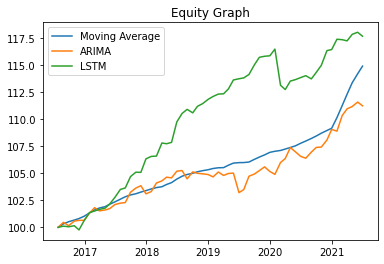

In [ ]:
plt.plot(timestamps, MA_equity,  label = "Moving Average")
plt.plot(timestamps, LR_equity, label = "ARIMA")
plt.plot(timestamps, LSTM_equity, label = "LSTM")
plt.title("Equity Graph")
plt.legend()
plt.show()

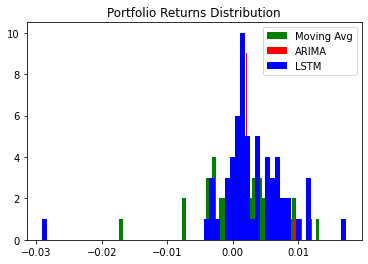

In [ ]:
plt.hist(LR_scipy_returns, bins = 60, label = 'Moving Avg', alpha = 1, color = 'green')
plt.title("Moving Average Portfolio Distribution")
#plt.legend()
#plt.show();
plt.hist(MA_scipy_returns, bins = 60, label = 'ARIMA', alpha = 1, color = 'red')
plt.title("ARIMA Portfolio Distribution")
#plt.legend()
#plt.show();
plt.hist(scipy_returns, bins = 60, label = 'LSTM', alpha = 1, color = 'blue') 
plt.title("Portfolio Returns Distribution")
plt.legend()
plt.show()

In [ ]:
print("Moving Average Ending Equity: " , MA_equity[-1])
print("Linear Regression Ending Equity: " , LR_equity[-1])
print("LSTM Ending Equity" , LSTM_equity[-1])

Moving Average Ending Equity:  114.92301944692984
Linear Regression Ending Equity:  111.2492616160397
LSTM Ending Equity 117.69085860325852


In [ ]:
import math
def metrics(returns): 
  sharpe = returns.mean() / returns.std()
  annualized_sharpe = sharpe.item() / math.sqrt(252)

  stdev = returns.std() 
  annualized_vol = stdev.item() / math.sqrt(252)


  return {"Annualized Sharpe Ratio": annualized_sharpe,
          "Annualized Volatility": annualized_vol}

In [ ]:
#Annualized info for Moving Average
metrics(np.array(MA_scipy_returns))

{'Annualized Sharpe Ratio': 0.06728386815230766,
 'Annualized Volatility': 0.0001400593165838116}

In [ ]:
#Annualized info for Linear Regression
metrics(np.array(LR_scipy_returns))

{'Annualized Sharpe Ratio': 0.021590927308423154,
 'Annualized Volatility': 0.0003160890481004423}

In [ ]:
#Annualized info for LSTM
metrics(np.array(scipy_returns))

{'Annualized Sharpe Ratio': 0.029639924788035177,
 'Annualized Volatility': 0.00036889409644620214}